# Run Sentiment Analysis on Forum Data
This notebook loads the Youbemom special needs forum text and compares sentiment pre- and during the COVID-19 pandemic

## Data Sources
- youbemomTables.db (scraped with 1-Scrape_Forum.ipynb)

## Changes
- 2020-08-13: Set up data cleaning
- 2020-08-20: Added t-tests
- 2020-08-26: Added plots

## Database Structure
- threads
 - id: automatically assigned
 - url: url of top post
- posts
 - id: automatically assigned
 - family_id: thread->id
 - message_id: the unique id of the message from the html
 - parent_id: id of post this post is responding to, 0 if top post
 - date_recorded: date the data is fetched
 - date_created: date the data was created
 - title: title of the post
 - body: body of the post

## TODO
- Does python have a regression function for continuous dependent variables between 0 and 1 or will I have to use R/Stata for a fractional regression model?
- Set up functions for the plots so I can plug in the variable I want to see
- Does sentiment differ between parents and children in threads?
 - Is sentiment more negative after negative posts? More positive after positive posts?
- Is there a time-dependent function here?
 - Seasonality?
 - Does tweaking the time period cutoffs affect the significance?
- Frequency distribution of words

## Imports

In [59]:
import sqlite3
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats import ttest_ind, kde
from datetime import datetime
# from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer #, word_tokenize
from nltk.corpus import stopwords
import string
import re
from pathlib import Path
import matplotlib.pyplot as plt

## Functions
For accessing the database

In [2]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as err:
        print(err)
    return conn

For formatting the data

In [3]:
def format_data(df):
    """ format the data frame from sql so dates are in
        datetime format and creates text column from
        title and body
    :param df: data frame
    :return df: formatted data frame
    """
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['date_created'] = pd.to_datetime(df['date_created'])
    # text = title + body
    df['title'] = df['title'].replace('This post has been deleted\.', '', regex=True)
    df['text'] = df['title'] + " " + df['body']
    return df

In [4]:
def clean_text(text):
    """ cleans the input text of punctuation, extra
        spaces, and makes letters lower case
    :param text: text (= title + body here)
    :return clean: clean text
    """
    clean = "".join([t for t in text if t not in string.punctuation])
    clean = re.sub(" +", " ", clean)
    clean = clean.strip()
    clean = clean.lower()
    return clean

In [5]:
def remove_stopwords(text):
    """ remove all stop words from the text
        using stopwords from nltk.corpus
    :param text: text with stopwords
    :return words: text without stopwords
    """
    words = [w for w in text if w not in stopwords.words('english')]
    return words

For creating the sentiment values

In [6]:
def sentiment_analyzer_scores(sentence, analyzer):
    """ create sentiment scores with the VADER analyzer
    :param sentence: sentence to create scores for
    :param analyzer: VADER sentiment analyzer
    :return score: a dictionary of scores (neg, neu, pos, compound)
    """
    score = analyzer.polarity_scores(sentence)
    return score

For running statistics

In [42]:
def ttest_sentiment(df, v):
    """ run a t-test on the sentiment scores for
        before and during the pandemic
    :param df: data frame
    :param v: the variable name to t-test on
    :return ttest: the t-test results
    """
    group_before = df.where(df['before'])[v].dropna()
    group_during = df.where(df['during'])[v].dropna()
    print("Mean before: " + str(group_before.mean()))
    print("Mean during: " + str(group_during.mean()))
    return ttest_ind(group_before, group_during, equal_var=False, nan_policy="omit")

For plotting

In [ ]:
# None yet

## File Locations

In [9]:
p = Path.cwd()
path_parent = p.parents[0]
path_db = path_parent / "database" / "youbemomTables.db"
path_db = str(path_db)
path_sentiment_data = path_parent / "clean_data" / "sentiment.csv"

## Variables

In [ ]:
# None yet

## Load Data

In [11]:
conn = sqlite3.connect(path_db)
df = pd.read_sql_query("SELECT * from posts", conn)

## Clean Data
Format the data to make dates into datetimes and create a text column from the title and body. Also, filter the data to include only dates starting Jan. 1, 2019. The scraper picked up one post from 2015 so this removes that.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27254 entries, 0 to 27253
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             27254 non-null  int64         
 1   family_id      27254 non-null  int64         
 2   message_id     27254 non-null  object        
 3   parent_id      27254 non-null  object        
 4   date_recorded  27254 non-null  datetime64[ns]
 5   date_created   27254 non-null  datetime64[ns]
 6   title          27254 non-null  object        
 7   body           27254 non-null  object        
 8   text           27254 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(5)
memory usage: 1.9+ MB


In [20]:
df = format_data(df)

In [34]:
df = df[(df['date_created']>pd.Timestamp(2019,1,1))]

In [44]:
df['before'] = df['date_created'] <= pd.Timestamp(2020,2,28)
df['during'] = df['date_created'] >= pd.Timestamp(2020,4,1)

## Add Sentiment Scores

In [23]:
analyzer = SentimentIntensityAnalyzer()

Including stop words and punctuation

In [24]:
sentiment = df['text'].apply(lambda x: sentiment_analyzer_scores(x, analyzer))
df['neg_sentiment'] = sentiment.apply(lambda x: x.get('neg', 0))
df['neu_sentiment'] = sentiment.apply(lambda x: x.get('neu', 0))
df['pos_sentiment'] = sentiment.apply(lambda x: x.get('pos', 0))
df['compound_sentiment'] = sentiment.apply(lambda x: x.get('compound', 0))

Without stop words or punctuation

In [25]:
text = df['text']
text = text.apply(clean_text)
tokenizer = RegexpTokenizer(r'\w+')
text = text.apply(tokenizer.tokenize)
text = text.apply(remove_stopwords)
df['text_clean'] = text.apply(lambda x: " ".join(x))
sentiment_clean = df['text_clean'].apply(lambda x: sentiment_analyzer_scores(x, analyzer))
df['neg_sentiment_clean'] = sentiment_clean.apply(lambda x: x.get('neg', 0))
df['neu_sentiment_clean'] = sentiment_clean.apply(lambda x: x.get('neu', 0))
df['pos_sentiment_clean'] = sentiment_clean.apply(lambda x: x.get('pos', 0))
df['compound_sentiment_clean'] = sentiment_clean.apply(lambda x: x.get('compound', 0))

## Statistical Analysis
This test looks at whether the average sentiment is different before (up to Feb. 28, 2020) and during the pandemic (after April 1, 2020)

In [45]:
print(ttest_sentiment(df, 'neg_sentiment'))
print(ttest_sentiment(df, 'neu_sentiment'))
print(ttest_sentiment(df, 'pos_sentiment'))
print(ttest_sentiment(df, 'compound_sentiment'))
print(ttest_sentiment(df, 'neg_sentiment_clean'))
print(ttest_sentiment(df, 'neu_sentiment_clean'))
print(ttest_sentiment(df, 'pos_sentiment_clean'))
print(ttest_sentiment(df, 'compound_sentiment_clean'))

Mean before: 0.06494482996422572
Mean during: 0.07025825183374085
Ttest_indResult(statistic=-2.25518289473822, pvalue=0.024174138207942363)
Mean before: 0.7818360415499378
Mean during: 0.782663508557458
Ttest_indResult(statistic=-0.18135753345823505, pvalue=0.8560956147596687)
Mean before: 0.1160214214904536
Mean during: 0.10734474327628352
Ttest_indResult(statistic=2.862065173222564, pvalue=0.004228914949499747)
Mean before: 0.11729874574371635
Mean during: 0.09018771393643076
Ttest_indResult(statistic=3.379261874125834, pvalue=0.0007333561369110925)
Mean before: 0.09346446273867547
Mean during: 0.10132915647921761
Ttest_indResult(statistic=-2.4453634590902653, pvalue=0.014512032279225916)
Mean before: 0.6644398948321218
Mean during: 0.6633154034229808
Ttest_indResult(statistic=0.20225303143053983, pvalue=0.8397286636157647)
Mean before: 0.19537144950648655
Mean during: 0.18493704156479226
Ttest_indResult(statistic=2.392966597165032, pvalue=0.01675559862705916)
Mean before: 0.15089811

With or with out stop words, the results show that sentiment is both more negative and less positive (p < 0.05 at least in all cases) during the pandemic compared to before the pandemic.

## Plots
Density plot comparing compound sentiment before and during the pandemic

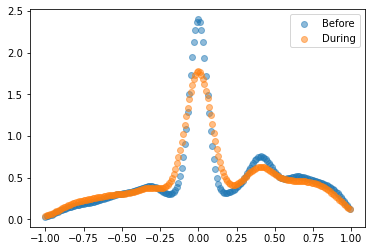

In [100]:
density_before = kde.gaussian_kde(df["compound_sentiment"][df['before']])
density_during = kde.gaussian_kde(df["compound_sentiment"][df['during']])
x = np.arange(-1.0, 1.0, 0.01)
plt.scatter(x, density_before(x), alpha=0.5, label="Before")
plt.scatter(x, density_during(x), alpha=0.5, label="During")
plt.legend(loc="upper right")
plt.show()

Scatter plot comparing daily average before and during the pandemic

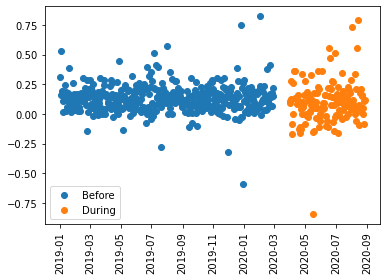

In [99]:
df['day'] = pd.to_datetime(df['date_created'], format="%Y-%m-%d")
daily_ave = df.resample('d', on='day').mean().dropna(how='all')
daily_ave['before'] = daily_ave.index <= pd.Timestamp(2020,2,28)
daily_ave['during'] = daily_ave.index >= pd.Timestamp(2020,4,1)
plt.scatter(daily_ave.index[daily_ave['before']], daily_ave['compound_sentiment'][daily_ave['before']], label="Before")
plt.scatter(daily_ave.index[daily_ave['during']], daily_ave['compound_sentiment'][daily_ave['during']], label="During")
plt.legend(loc="lower left")
plt.xticks(rotation=90)
plt.show()